Auteur : David Paulino
# Expected Goals
Ce Jupyter Notebook a pour but d'être un support pour la rédaction du Travail de Bachelor nommé "Analyse et optimisation de l'expected goal : application au machine learning" 

Assurez-vous d'avoir installé les librairies suivantes :
- numpy
- pandas
- matplotlib
- mplsoccer

In [176]:
# Import des libs
import pandas as pd
import numpy as np
import json
# Plotting
import matplotlib.pyplot as plt
# Permet de plot des terrains de football
from mplsoccer import VerticalPitch, Pitch, Standardizer
# Nécessaire à l'import des datasets
import os
import pathlib
import seaborn as sns
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Permet d'éviter les warnings
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Données
La première partie de notebook vise à importer, visualiser et observer les caractéristiques de chacun des attributs du dataset. Cela va permettre de mieux comprendre le dataset dans son ensemble, d'observer d'éventuelles données manquantes et de pouvoir prédire à l'avance d'éventuels comportements.

In [150]:
# Chargement des données events
train = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'events')

# Permet de récupérer tous les fichiers dans le dossier /TB/events
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
for file_name in onlyfiles:
    path_to_file = mypath + "/" + file_name
    
    with open(path_to_file) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])

In [151]:
# Chargement des données de joueurs
players = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'players')

# Insérer les données du fichier players.json dans le dataframe players
with open(mypath + "/players.json") as f:
    data = json.load(f)
    players = pd.DataFrame(data)


Maintenant, nous allons filtrer uniquement par les données qui nous intéressent, à savoir les tirs.
On utilise "subEventName" pour retirer les penaltys.

In [152]:
shots = train[train["subEventName"] == "Shot"]


In [153]:
print(shots.shape)

(43078, 12)


# Pré-visualisation
## Position des tirs

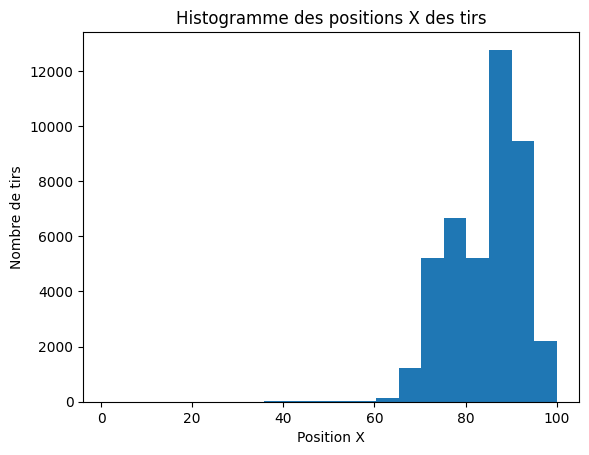

In [154]:
# Histogramme des positions X des tirs
# X représente la longueur du terrain malgré le fait que le terrain soit en 100x100

x_pos = shots["positions"].apply(lambda x: x[0]["x"])
plt.hist(x_pos, bins=20)
plt.title("Histogramme des positions X des tirs")
plt.xlabel("Position X")
plt.ylabel("Nombre de tirs")
#plt.ylim(0, 10)
plt.show()

On peut voir que tous les tirs sont effectuées dans la partie haute du terrain. Cependant, il est important de noter que les tirs ont été normalisés par rapport au sens du but. Ainsi, tous les tirs effectués dans le but adverse sont considérés comme des tirs dans la partie haute du terrain. On peut notamment le voir dans le graphique qui suit.

Text(0.5, 1.0, 'Positions des 1000 premiers tirs')

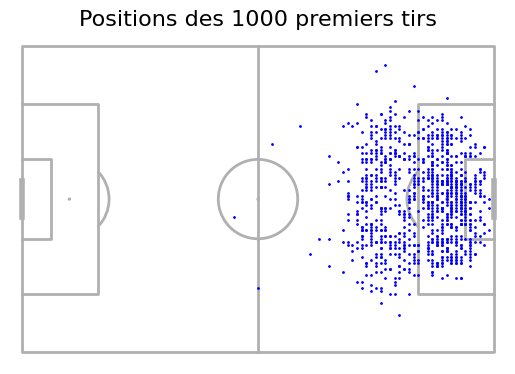

In [155]:
# Affichage des 1000 premibers tirs sur un terrain
# On peut voir qu'ils sont tous dans une seule moitié de terrain alors qu'un match se joue dans les deux sens
# Les données utilisées viennent de Wyscout

pitch = Pitch(pitch_type='wyscout')

fig, ax = pitch.draw(constrained_layout=True, tight_layout=False)

pitch.scatter(x_pos[:1000], shots["positions"].apply(lambda x: x[0]["y"])[:1000], ax=ax, s=1, color='blue')
ax.set_title("Positions des 1000 premiers tirs", fontsize=16)

# Transformation des données
Le but de la transformation de données est de convertir les positions X et Y en mètres. Suite à cela, nous allons pouvoir calculer la distance entre le tireur et le but adverse. Ensuite, nous allons également calculer l'angle de tir. Ces deux nouvelles caractéristiques vont nous permettre d'établir correctement un modèle d'expected goals.

In [156]:
# Taille du terrain
pitch_size = (105, 68)
# On transforme d'abord les positions des tirs correctements
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * pitch_size[0]/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * pitch_size[1]/100)
# Utile pour le calcul de la distance au but et de l'angle de tir
# L'attribut C est un équivalent de Y mais il permet de situer le but en position 0, 0
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * pitch_size[1]/100)
#print(shots[["X", "Y", "C"]].head())

In [157]:
# Les coordonnées du but sont (0, 50). On peut le voir sur le glossaire de Wyscout dans "Pitch Coordinates"
# Cependant, on a besoin de les transformer pour qu'elles soient dans le même format que les positions des tirs
# Pour rappel, la taille du terrain est de 105x68
# On choisit également le but en 0, 50 car cela nous permettra de calculer l'angle du tir par rapport au but
goal_coordinates = np.array([0*pitch_size[0]/100, 50*pitch_size[1]/100])
print(goal_coordinates)

# Largeur du but
goal_width = 7.32
# On calcule la distance entre le but et le tir avec la dimension 105x68
shots["distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)

# Calcul de l'angle avec la fonction utilisée et expliqué dans la thèse.
shots["angle"] = np.pi - \
                    (np.arctan( (shots["C"] - goal_width/2) / shots["X"]) + np.pi/2) - \
                    (np.pi/2 - np.arctan( (shots["C"] + goal_width/2) / shots["X"]))
# Angle basé sur le centre du terrain
shots["angle_abs"] = np.arctan(shots["C"] / shots["X"])

shots["goal"] = shots["tags"].apply(lambda cell: 101 in [tag["id"] for tag in cell])

shots["header"] = shots["tags"].apply(lambda cell: 403 in [tag["id"] for tag in cell])

def extract_good_foot(tags):
    for tag in tags:
        if tag['id'] == 401:
            return 'left'
        elif tag['id'] == 402:
            return 'right'
    return None  # Retourne None si aucun pied correspondant n'est trouvé

shots["foot_used_on_shot"] = shots["tags"].apply(extract_good_foot)



[ 0. 34.]


# Fusion des datasets

In [158]:
# Le but de la fusion de dataset est de récupérer les informations des joueurs qui ont tiré
# Parmi ces informations on va récupérer le pied fort du joueur
# On va donc comparer si le pied fort du joueur est le même que le pied utilisé pour tirer

# On récupère les informations des joueurs qui ont tiré
shots = shots.merge(players[["wyId", "foot"]], left_on="playerId", right_on="wyId", how="inner")
# On calcule quel est le bon pied pour chaque tir
shots["good_foot_used"] = shots["foot"] == shots["foot_used_on_shot"]



In [159]:
# On prend uniquement les attributs qui nous intéressent
shots = shots[["X", "Y", "distance", "angle", "angle_abs", "goal", "header", "good_foot_used"]]

print(shots[10:20])

                        

        X      Y   distance     angle  angle_abs   goal  header   
10  26.25  42.16  27.489054  0.253313   0.301387  False   False  \
11  25.20  42.84  26.705535  0.257736   0.337382  False   False   
12  15.75  22.44  19.537044  0.303370   0.633162   True   False   
13  19.95  46.92  23.768233  0.258838   0.574700  False   False   
14  17.85  46.24  21.643477  0.279618   0.601074  False   False   
15   9.45  46.24  15.463509  0.297367   0.913326  False   False   
16  25.20  40.80  26.101341  0.269474   0.263564  False   False   
17   7.35  40.80  10.013116  0.554534   0.746548  False   False   
18  12.60  19.72  19.044117  0.258168   0.847817  False   False   
19   7.35  27.88   9.564356  0.603340   0.694337  False    True   

    good_foot_used  
10            True  
11           False  
12            True  
13            True  
14            True  
15            True  
16            True  
17            True  
18            True  
19           False  


# Visualisation des données
## Description des données numériques

In [160]:
shots.describe()

,X,Y,distance,angle,angle_abs
count,43075.000000,43075.000000,43075.000000,43075.000000,43075.000000
mean,15.992225,33.473176,18.593067,0.414140,0.484041
std,8.534333,9.366171,8.419298,0.253173,0.313051
min,0.000000,0.000000,0.680000,0.000000,0.000000
25%,9.450000,26.520000,12.249445,0.250188,0.227296
50%,13.650000,33.320000,17.153297,0.327782,0.452154
75%,23.100000,40.800000,24.936000,0.505984,0.699776
max,103.950000,68.000000,103.952224,3.141593,1.570796


## Position de tous les tirs sous formes de heatmap

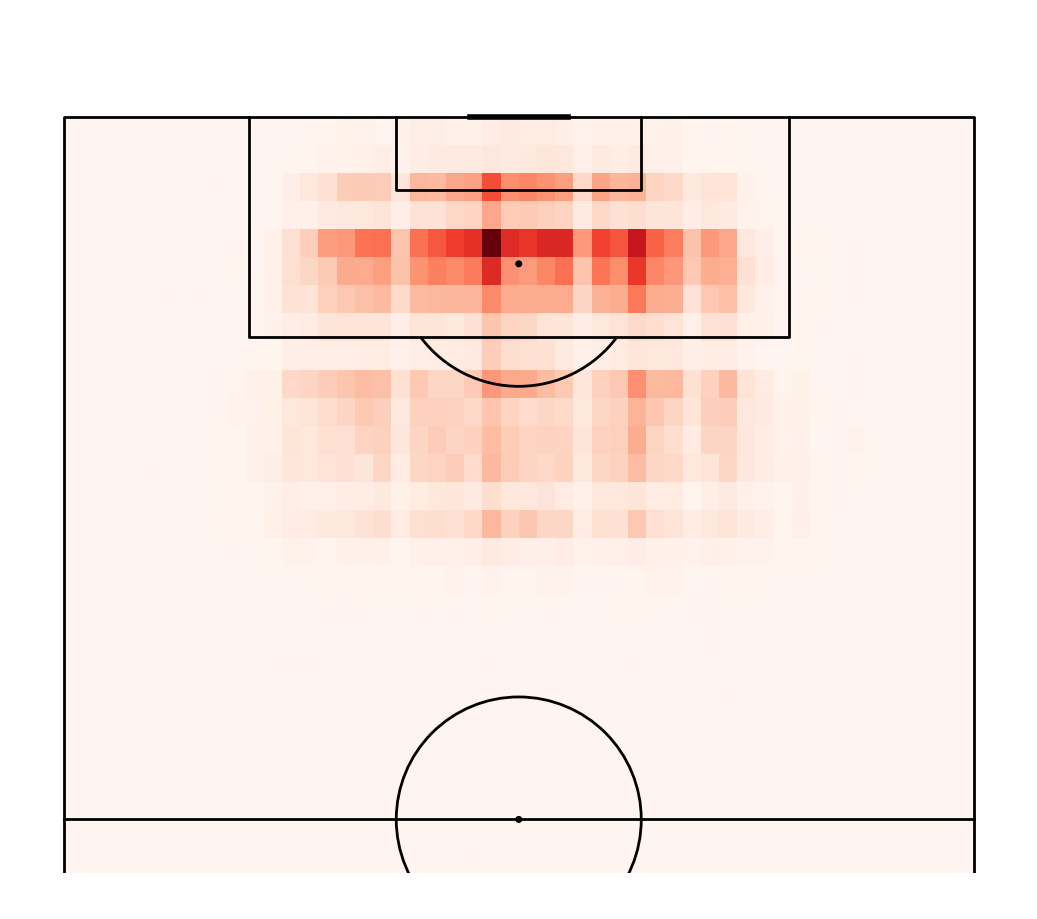

In [161]:
# Le but est d'afficher une moitié de terrain avec une heatmap qui montre la fréquence des positions des tirs

# On crée un terrain avec la librairie mplsoccer. La taille du terrain est de 105x68
# On doit obligatoirement mettre "line_zorder = 2" pour que le terrain soit affiché correctement sur la heatmap
pitch = VerticalPitch(line_color="black", pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2, half=True)

# Il faut mettre une grille sur le terrain pour pouvoir afficher la heatmap
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# On affiche la heatmap avec la fonction heatmap de la librairie mplsoccer
# On prépare les données avec la fonction bin_statistic qui permet de compter le nombre de tirs dans chaque case
# 105-shots.X car autrement les tirs sont affichés de l'autre côté du terrain
bin_statistics_shot = pitch.bin_statistic(105-shots.X, shots.Y, bins=(50, 50))
pitch.heatmap(bin_statistics_shot, ax=ax["pitch"], cmap='Reds', edgecolors='white', linewidth=0)


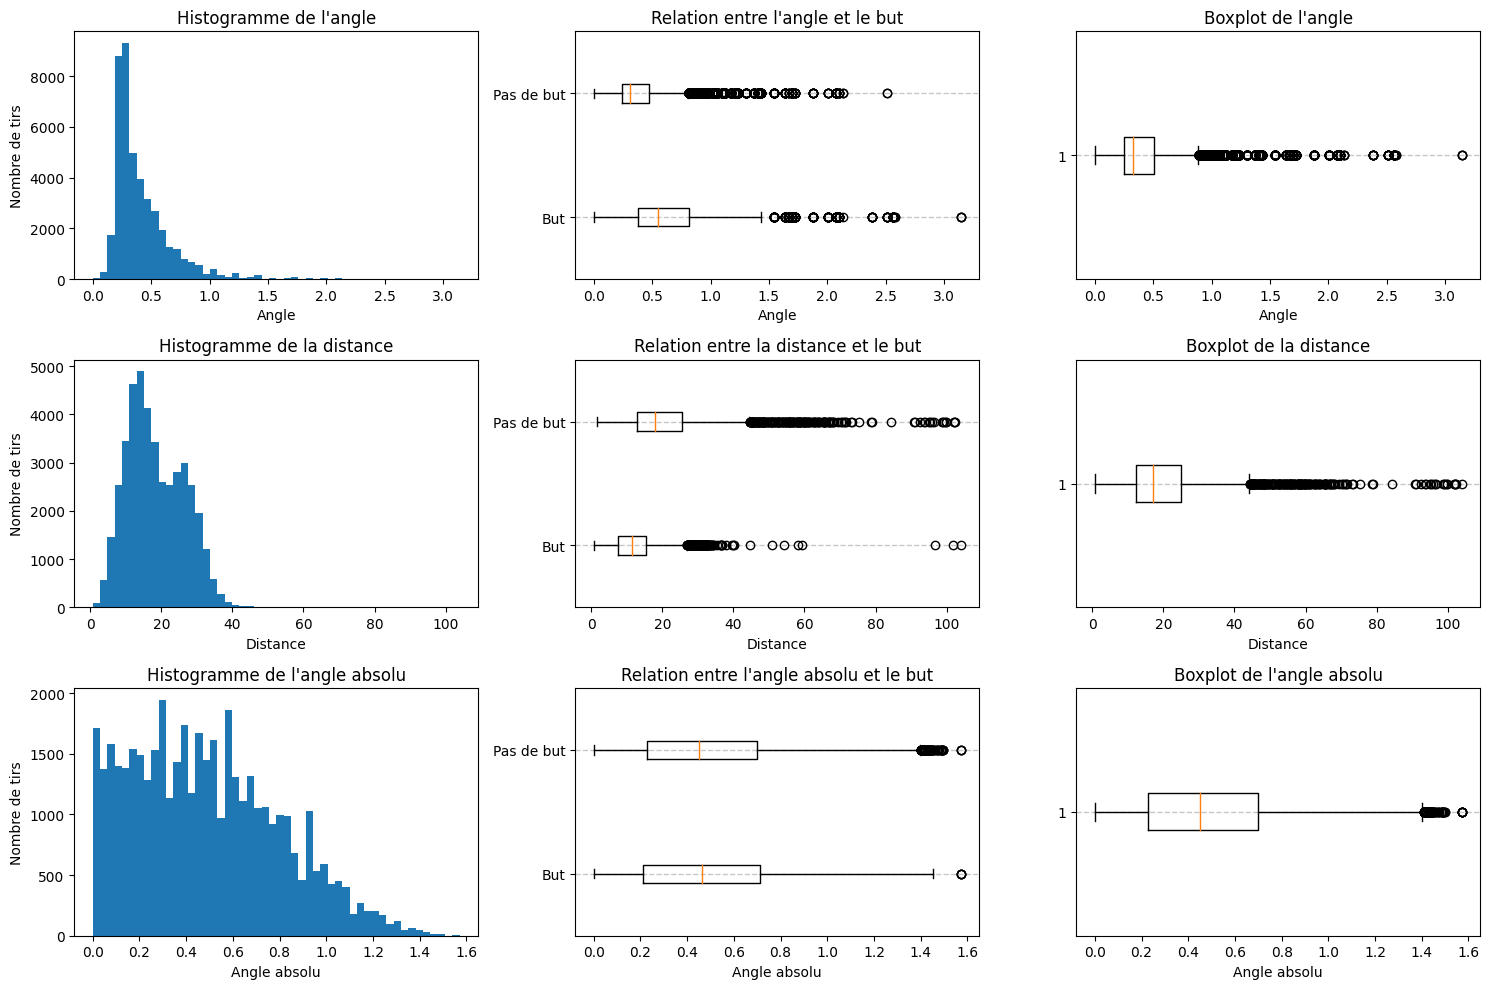

In [162]:
import matplotlib.pyplot as plt

# Créer un subplot avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Histogramme de l'angle
axes[0,0].hist(shots["angle"], bins=50)
axes[0,0].set_xlabel("Angle")
axes[0,0].set_ylabel("Nombre de tirs")
axes[0,0].set_title("Histogramme de l'angle")


# # Affichage d'un boxplot par valeur possible de goal pour l'angle
axes[0,1].boxplot([shots[shots["goal"] == True]["angle"], shots[shots["goal"] == False]["angle"]], vert=False)
axes[0,1].set_xlabel("Angle")
axes[0,1].set_title("Relation entre l'angle et le but")
# Changer le nom des catégories
axes[0,1].set_yticks([1, 2], ["But", "Pas de but"])
axes[0,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
# Affichage d'un boxplot pour l'angle
axes[0,2].boxplot(shots["angle"], vert=False)
axes[0,2].set_xlabel("Angle")
axes[0,2].set_title("Boxplot de l'angle")
axes[0,2].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Histogramme de la distance
axes[1,0].hist(shots["distance"], bins=50)
axes[1,0].set_xlabel("Distance")
axes[1,0].set_ylabel("Nombre de tirs")
axes[1,0].set_title("Histogramme de la distance")

# Affichage d'un boxplot par valeur possible de goal pour la distance
axes[1,1].boxplot([shots[shots["goal"] == True]["distance"], shots[shots["goal"] == False]["distance"]], vert=False)
axes[1,1].set_xlabel("Distance")
axes[1,1].set_title("Relation entre la distance et le but")
# Changer le nom des catégories
axes[1,1].set_yticks([1, 2], ["But", "Pas de but"])
axes[1,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
# Affichage d'un boxplot pour la distance
axes[1,2].boxplot(shots["distance"], vert=False)
axes[1,2].set_xlabel("Distance")
axes[1,2].set_title("Boxplot de la distance")
axes[1,2].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Histogramme de la distance
axes[2,0].hist(shots["angle_abs"], bins=50)
axes[2,0].set_xlabel("Angle absolu")
axes[2,0].set_ylabel("Nombre de tirs")
axes[2,0].set_title("Histogramme de l'angle absolu")

# Affichage d'un boxplot par valeur possible de goal pour l'angle
axes[2,1].boxplot([shots[shots["goal"] == True]["angle_abs"], shots[shots["goal"] == False]["angle_abs"]], vert=False)
axes[2,1].set_xlabel("Angle absolu")
axes[2,1].set_title("Relation entre l'angle absolu et le but")
# Changer le nom des catégories
axes[2,1].set_yticks([1, 2], ["But", "Pas de but"])
axes[2,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
# Affichage d'un boxplot pour l'angle absolu
axes[2,2].boxplot(shots["angle_abs"], vert=False)
axes[2,2].set_xlabel("Angle absolu")
axes[2,2].set_title("Boxplot de l'angle absolu")
axes[2,2].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()

# Afficher le subplot
plt.show()

In [163]:
# Methode pour trouver les outliers
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]
    return outliers

# Lister les outliers
outliers_distance = find_outliers(shots, "distance")
outliers_angle = find_outliers(shots, "angle")
outliers_angle_abs = find_outliers(shots, "angle_abs")

# Afficher le nombre d'outliers
print("Nombre d'outliers pour la distance :", len(outliers_distance))
print("Nombre d'outliers pour l'angle :", len(outliers_angle))
print("Nombre d'outliers pour l'angle absolu :", len(outliers_angle_abs))





Nombre d'outliers pour la distance : 197
Nombre d'outliers pour l'angle : 2163
Nombre d'outliers pour l'angle absolu : 70


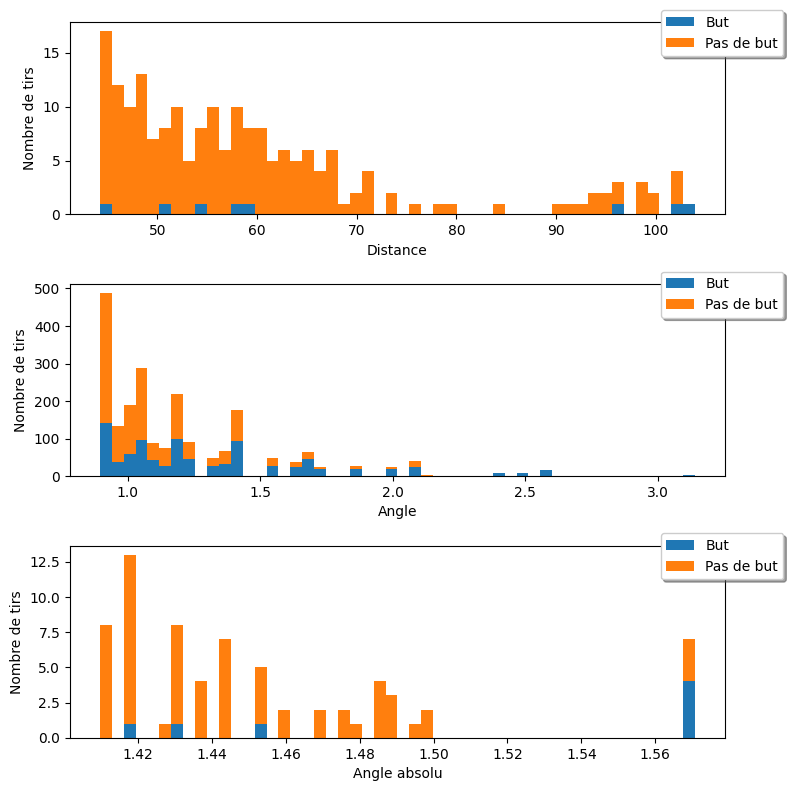

In [164]:
# Barplot de la proportion des buts marqués pour l'outlier de la distance
fig, ax = plt.subplots(3, figsize=(8, 8))
ax[0].hist([
        outliers_distance[outliers_distance["goal"] == True]["distance"], 
        outliers_distance[outliers_distance["goal"] == False]["distance"]], 
        bins=50, 
        stacked=True, 
        label=["But", "Pas de but"])
ax[0].set_xlabel("Distance")
ax[0].set_ylabel("Nombre de tirs")
ax[0].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# On peut remarquer qu'il y a uniquement 3 buts qui sont fait à une 
# très haute distance. Sachant que l'on peut observer que le reste des tirs
# à cette distance n'ont pas été marqué, on peut supposer que ces 3 buts
# sont des outliers.

ax[1].hist([
        outliers_angle[outliers_angle["goal"] == True]["angle"], 
        outliers_angle[outliers_angle["goal"] == False]["angle"]], 
        bins=50, 
        stacked=True, 
        label=["But", "Pas de but"])
ax[1].set_xlabel("Angle")
ax[1].set_ylabel("Nombre de tirs")
ax[1].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# On remarque qu'il n'y a pas grand chose à dire sur ces outliers.
# Plus l'angle est grand plus il y a de buts mais on voit sur l'histogramme
# que la proportion de buts marqués est similaires à celle des buts manqués. au même angle
# Barplot de la proportion des buts marqués pour l'outlier de la distance
ax[2].hist([
        outliers_angle_abs[outliers_angle_abs["goal"] == True]["angle_abs"], 
        outliers_angle_abs[outliers_angle_abs["goal"] == False]["angle_abs"]], 
        bins=50, 
        stacked=True, 
        label=["But", "Pas de but"])
ax[2].set_xlabel("Angle absolu")
ax[2].set_ylabel("Nombre de tirs")
ax[2].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# Pareil que pour l'angle, il n'y a pas grand chose à dire sur ce graphique.
plt.tight_layout()
plt.show()


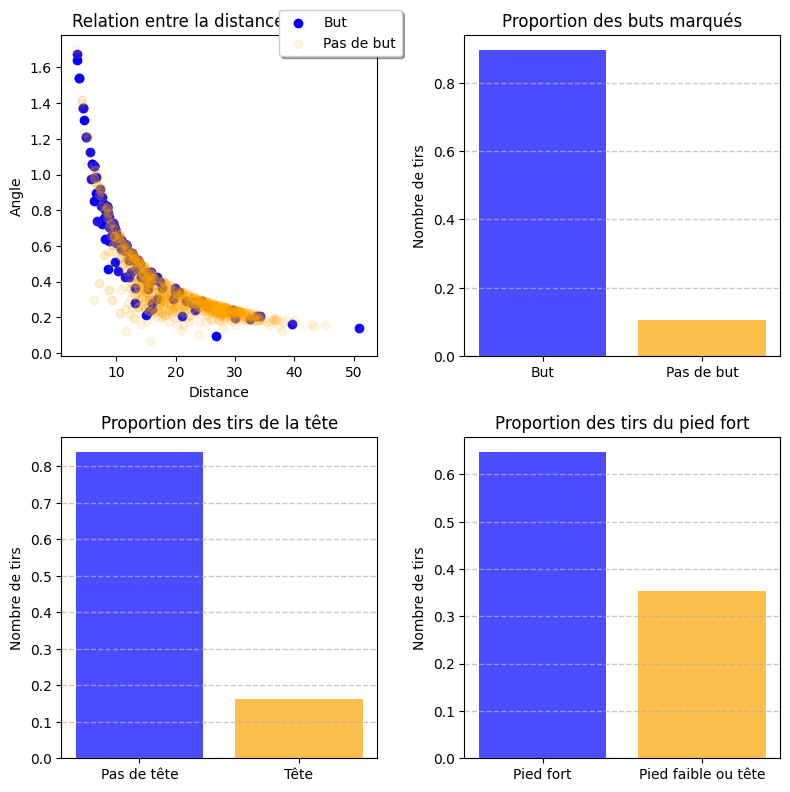

In [165]:
# Affichage des autres graphiques
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Affichage de la relation entre la distance et l'angle
# Les points en bleu seront uniquement les buts marqués
# Les points en orange seront uniquement les buts manqués
first_1000_shots = shots[:1000]

ax[0,0].scatter(
        first_1000_shots[first_1000_shots["goal"] == True]["distance"],
        first_1000_shots[first_1000_shots["goal"] == True]["angle"],
        c="blue",
        label="But",
        alpha=1)
ax[0,0].scatter(
        first_1000_shots[first_1000_shots["goal"] == False]["distance"],
        first_1000_shots[first_1000_shots["goal"] == False]["angle"],
        c="orange",
        label="Pas de but",
        alpha=0.1)
ax[0,0].set_xlabel("Distance")
ax[0,0].set_ylabel("Angle")
ax[0,0].set_title("Relation entre la distance et l'angle")
ax[0,0].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# Barplot pour afficher la proportion des buts

counting_values = shots["goal"].value_counts(normalize=True)
ax[0,1].bar(
        ["But", "Pas de but"],
        counting_values,
        color=["blue", "orange"],
        alpha=0.7)
ax[0,1].set_ylabel("Nombre de tirs")
ax[0,1].set_title("Proportion des buts marqués")
ax[0,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Affichage d'un barplot pour la proportion des tirs de la tête
counting_values = shots["header"].value_counts(normalize=True)
ax[1,0].bar(
        ["Pas de tête", "Tête"],
        counting_values,
        color=["blue", "orange"],
        alpha=0.7)
ax[1,0].set_ylabel("Nombre de tirs")
ax[1,0].set_title("Proportion des tirs de la tête")
ax[1,0].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Affichage d'un barplot pour la proportion des tirs du pied fort
counting_values = shots["good_foot_used"].value_counts(normalize=True)
ax[1,1].bar(
        ["Pied fort", "Pied faible ou tête"],
        counting_values,
        color=["blue", "orange"],
        alpha=0.7)
ax[1,1].set_ylabel("Nombre de tirs")
ax[1,1].set_title("Proportion des tirs du pied fort")
ax[1,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)




plt.tight_layout()
plt.show()


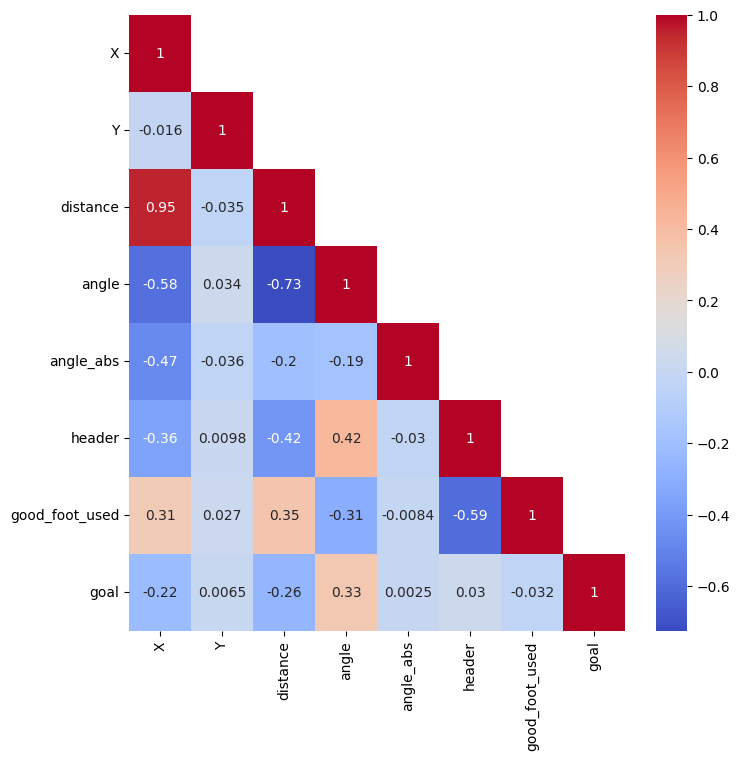

In [166]:
# Matrice de corrélation de tout le dataset
# Goal à la fin du dataset pour simplifier la visualisation
shots = shots[["X", "Y", "distance", "angle", "angle_abs", "header", "good_foot_used", "goal"]]

corr = shots.corr()
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm", mask=np.triu(corr, k=1))
plt.show()

# Via cette matrice de corrélation on peut voir que la distance et l'angle
# ont une grande corrélation pour déterminer si un tir est un but ou non.
# C'est également le cas pour la position X. et c'est normal puisque
# elle est étroitement corrélé avec la distance

## Suppression des outliers

In [167]:
# Suppression des outliers pour la distance
# On va supprimer les outliers qui ont une distance supérieur à 90 mètres et qui sont des buts
print("Nombre de tirs avant suppression :", len(shots))
shots = shots.drop(shots[(shots["distance"] > 90) & (shots["goal"] == True)].index)
print("Nombre de tirs après suppression :", len(shots))
# On a bien supprimé les trois outliers de la distanceb

Nombre de tirs avant suppression : 43075
Nombre de tirs après suppression : 43072


# Modèle d'expected goals
## Séparation des données en train et test

In [168]:
# Nous devons d'abord créer une séparation entre les données d'entrainement et de test
# On va utiliser la fonction train_test_split de sklearn
# On va utiliser 90% des données pour l'entrainement et 10% pour le test
X = shots.drop("goal", axis=1)
y = shots["goal"]

# Le test sera utilisé pour la validation finale du modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Nombre de données d'entrainement :", len(X_train))
print("Nombre de données de test :", len(X_test))

Nombre de données d'entrainement : 38764
Nombre de données de test : 4308


In [1]:

kf = KFold(n_splits=10, shuffle=True, random_state=42)

model = LogisticRegression()
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
print("Moyenne des scores :", scores.mean())
print("Ecart-type des scores :", scores.std())

model = DecisionTreeClassifier()
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
print("Moyenne des scores :", scores.mean())
print("Ecart-type des scores :", scores.std())

model = RandomForestClassifier()
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
print("Moyenne des scores :", scores.mean())
print("Ecart-type des scores :", scores.std())

model = MLPClassifier()
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
print("Moyenne des scores :", scores.mean())
print("Ecart-type des scores :", scores.std())

model = SVC()
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
print("Moyenne des scores :", scores.mean())
print("Ecart-type des scores :", scores.std())




NameError: name 'KFold' is not defined